In [31]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import math
from math import sqrt
import os
from pathlib import Path
import pylab as pl
import statsmodels.api as sm
import seaborn as sns

#default setting for charts
sns.set(font_scale=1.3)
plt.style.use('seaborn-whitegrid')

In [32]:
# Import S&P 500 Index and Sectors log return data

full_path = os.path.abspath(os.curdir)
stock_data_url = str(Path(full_path).parents[0])+"\datasets\Stock Data/"
sp500_aggregate_url = "spark_calculations\S&P_500_aggregate\S&P_500_aggregate_Cum_Sums.csv"
sp500_sector_url = "spark_calculations\Sectoral\Sector_Cum_Sums.csv"

sp500 = pd.read_csv(stock_data_url + sp500_aggregate_url, index_col= 'Date', 
                 infer_datetime_format = True, parse_dates = True)

sector = pd.read_csv(stock_data_url + sp500_sector_url, index_col= 'Date', 
                 infer_datetime_format = True, parse_dates = True)

sp500=sp500.rename({"Log Return": "SP500 Log"}, axis='columns')
sp500.head()

,Symbol,Name,SP500 Log,CumulativeSum
Date,,,,
2019-11-15,^GSPC,S&P 500,0.000000,0.000000
2019-11-18,^GSPC,S&P 500,0.000503,0.000503
2019-11-19,^GSPC,S&P 500,-0.000593,-0.000090
2019-11-20,^GSPC,S&P 500,-0.003763,-0.003853
2019-11-21,^GSPC,S&P 500,-0.001584,-0.005437


In [33]:
sector.head()
sector.count()
#sector.groupby("Symbol").tail()

Symbol           2772
Name             2772
Log Return       2772
CumulativeSum    2772
dtype: int64

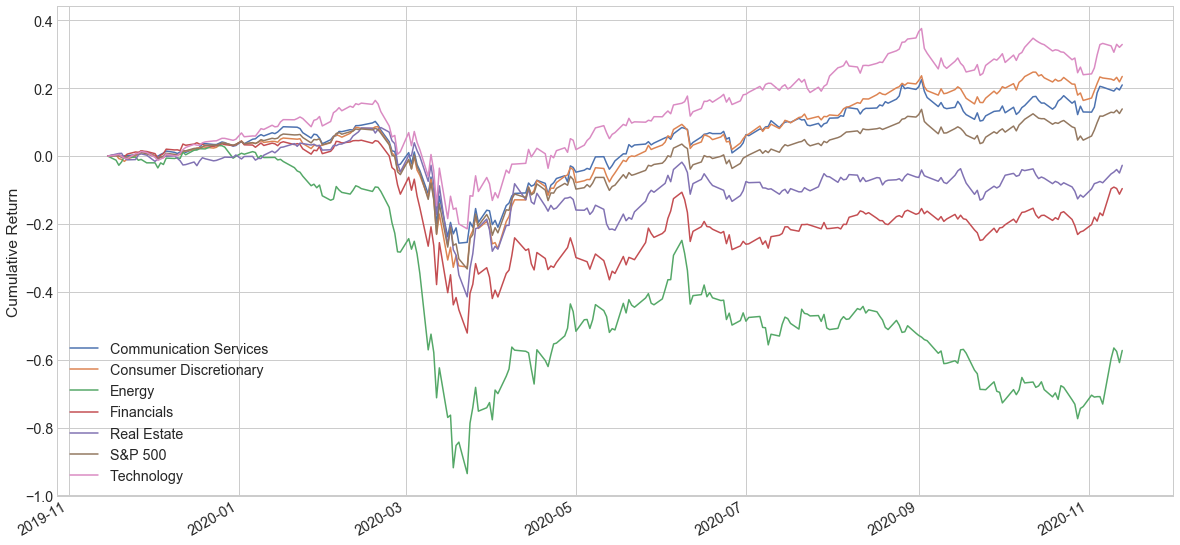

In [34]:
#1 Plot Sector Cumulative Returns for Best and Worst Performers vs. S&P 500 index

select = ['XLK','XLY','XLC','XLE','XLF','XLRE', "^GSPC"]
combined = pd.concat([(sector), (sp500)], 
                      axis = 'rows', join = 'inner')
best_worst= combined[combined['Symbol'].isin(select)]

fig = plt.figure()
ax1 = plt.axes()
best_worst.groupby("Name")["CumulativeSum"].plot(figsize=(20,10), legend = True, title ="")
y_axis = ax1.axes.get_yaxis()
y_axis.set_label_text('Cumulative Return')
x_axis = ax1.axes.get_xaxis()
x_axis.set_label_text('')
plt.show()

#sector.groupby("Name")["CumulativeSum"].plot(figsize=(20,10), title = 'Cumulative Sector Returns', legend = True)

fig.savefig('sectors_cum_returns.png')
#plt.close()

In [35]:
#2 Event Study: Sectors Reactions to Most Significant Covid-related Events

#Pre-Covid window period - Nov 18, 2019 to February 19, 2020
sp500_pre = sp500['SP500 Log']['2019-11-18':'2020-02-19'] # starts on 11/18/19 since log return=0 on 11/15/19
sector_pre = sector[['Name','Log Return']]['2019-11-18':'2020-02-19']

sp_all_pre = pd.concat([(sector_pre), (sp500_pre)], 
                      axis = 'columns', join = 'inner')

sp_all_pre.head()


,Name,Log Return,SP500 Log
Date,,,
2019-11-18,Materials,-0.002488,0.000503
2019-11-19,Materials,-0.002161,-0.000593
2019-11-20,Materials,-0.012562,-0.003763
2019-11-21,Materials,-0.001687,-0.001584
2019-11-22,Materials,0.001687,0.002173


In [36]:
# Calculate regression parameters

def regress(data,yvar,xvars):
    Y=data[yvar]
    X=data[xvars]
    X=sm.add_constant(X)
    result = sm.OLS(Y,X).fit()
    #print('Parameters: ', result.params)
    #print('R2: ', result.rsquared)
    #print(dir(result))
    return (result.params.round(5).tolist(), result.rsquared.round(2), result.pvalues['SP500 Log'].round(3))

param = sp_all_pre.groupby('Name').apply(regress,'Log Return',['SP500 Log'])

df=pd.DataFrame(param.tolist(), columns=['Param','R2','p-value'], index=param.index)
df[['Intercept','Coefficient']]= pd.DataFrame(df['Param'].tolist(), index=df.index)
df = df.drop(columns=['Param'])
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]
df.head(11)



,Intercept,Coefficient,R2,p-value
Name,,,,
Communication Services,0.00044,0.90808,0.63,0.000
Consumer Discretionary,0.00026,0.84883,0.61,0.000
Consumer Staples,0.00033,0.36313,0.25,0.000
Energy,-0.00306,1.24728,0.38,0.000
Financials,-0.00071,1.10278,0.74,0.000
Health Care,-0.00015,0.91835,0.64,0.000
Industrials,-0.00111,1.12521,0.74,0.000
Materials,-0.00146,1.15962,0.66,0.000
Real Estate,0.00058,0.38065,0.08,0.021


In [37]:
# Get S&P 500 index data for 10 Covid-related events (top gains and losses)

sp500_gains_drops_url = "GainsDrops.csv"
sp500_events = pd.read_csv(stock_data_url + sp500_gains_drops_url,index_col= 'Date', 
                 infer_datetime_format = True, parse_dates = True)

sp500_events=sp500_events.reset_index()
sp500_events=sp500_events.rename({"Log Return": "SP500 Log"}, axis='columns')
sp500_events.head(10) 

,Date,SP500 Log,News
0,2020-03-09,-0.079010,Fear of coronavirus outbreak and oil price war
1,2020-03-12,-0.099945,Trump bans travel from Europe to US
2,2020-03-13,0.088808,U.S. House passes coronavirus bill on Saturday
3,2020-03-16,-0.127652,Trump urges U.S. to halt most social activity ...
4,2020-03-17,0.058226,Global powers unleash trillions of dollars to ...
5,2020-03-18,-0.053222,Concerns over the economic destruction from th...
6,2020-03-24,0.089683,Congress nears $2 trillion aid package
7,2020-03-26,0.060544,Powell pledges the Fed still has room to fight...
8,2020-04-06,0.067968,New virus infections count in the U.S. dipped ...
9,2020-06-11,-0.060753,Fed keeping rates steady through 2022 with war...


In [38]:
#Calculate abnormal returns (actual return - expected return)

sector=sector.reset_index()
sector_reg = pd.merge(sector, df, 
                          left_on='Name',
                          right_on='Name')

event_days = pd.merge(sector_reg, sp500_events, 
                          left_on='Date',
                          right_on='Date')

event_days = event_days.set_index('Date')
event_days=event_days.drop(columns=['CumulativeSum', 'R2', 'p-value'])
event_days['Expected Return'] = event_days['Intercept'] + (event_days['Coefficient']*event_days['SP500 Log'])
event_days['Abnormal Return'] = event_days['Log Return']-event_days['Expected Return']

event_days.head()


,Symbol,Name,Log Return,Intercept,Coefficient,SP500 Log,News,Expected Return,Abnormal Return
Date,,,,,,,,,
2020-03-09,XLB,Materials,-0.098266,-0.00146,1.15962,-0.07901,Fear of coronavirus outbreak and oil price war,-0.093082,-0.005184
2020-03-09,XLC,Communication Services,-0.068964,0.00044,0.90808,-0.07901,Fear of coronavirus outbreak and oil price war,-0.071308,0.002344
2020-03-09,XLE,Energy,-0.224910,-0.00306,1.24728,-0.07901,Fear of coronavirus outbreak and oil price war,-0.101608,-0.123302
2020-03-09,XLF,Financials,-0.113438,-0.00071,1.10278,-0.07901,Fear of coronavirus outbreak and oil price war,-0.087841,-0.025597
2020-03-09,XLI,Industrials,-0.096733,-0.00111,1.12521,-0.07901,Fear of coronavirus outbreak and oil price war,-0.090013,-0.006720


<Figure size 432x288 with 0 Axes>

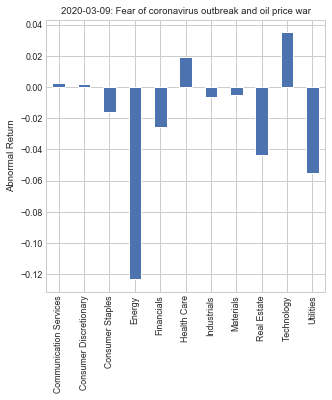

<Figure size 432x288 with 0 Axes>

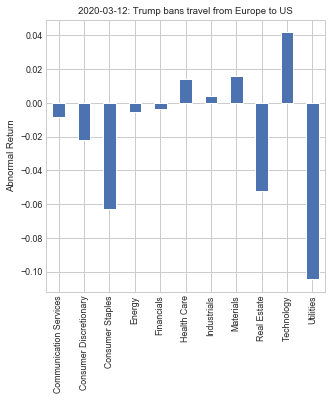

<Figure size 432x288 with 0 Axes>

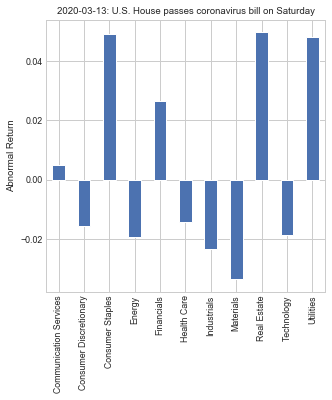

<Figure size 432x288 with 0 Axes>

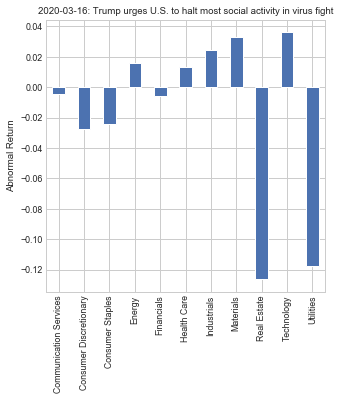

<Figure size 432x288 with 0 Axes>

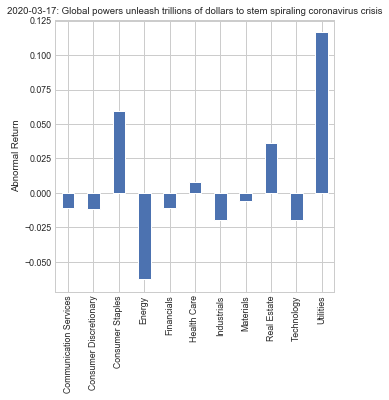

<Figure size 432x288 with 0 Axes>

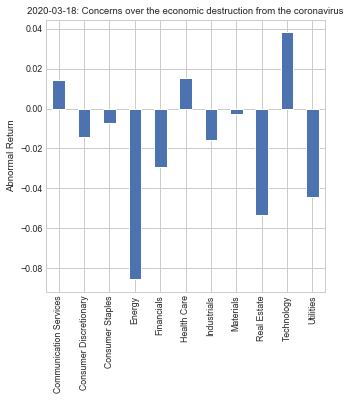

<Figure size 432x288 with 0 Axes>

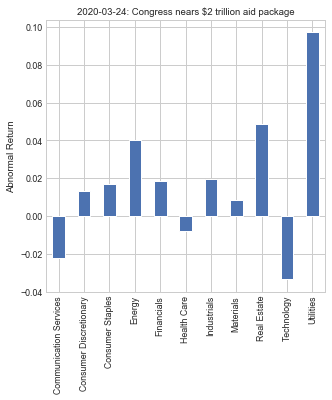

<Figure size 432x288 with 0 Axes>

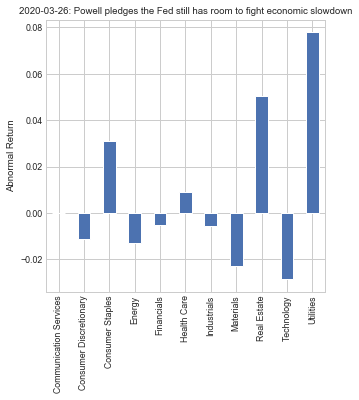

<Figure size 432x288 with 0 Axes>

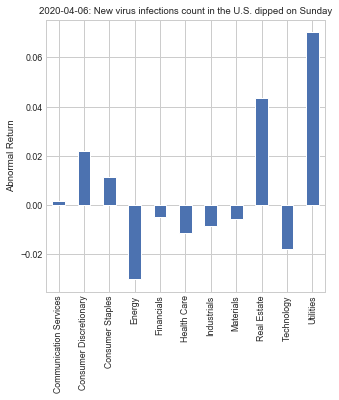

<Figure size 432x288 with 0 Axes>

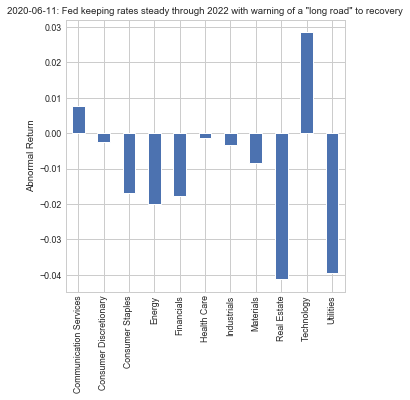

In [39]:
#Plot abnormal returns for each date

dates = ['2020-03-09','2020-03-12','2020-03-13','2020-03-16', '2020-03-17', '2020-03-18', '2020-03-24',
         '2020-03-26','2020-04-06','2020-06-11']
news = event_days['News'].drop_duplicates().to_list()

event = [(dates[i], news[i]) for i in range(0, len(dates))]
#print(event)

sns.set(font_scale=0.8)
plt.style.use('seaborn-whitegrid')

for (d,n) in event:
    fig = plt.figure()
    event_days_sum= event_days[d:d].groupby("Name").sum()
    event_days_sum[['Abnormal Return']].plot.bar(figsize=(5,5),title =  d +': '+ n , legend = False)
    plt.xlabel("")
    plt.ylabel("Abnormal Return")
    plt.savefig('sectors_abn_returns'+d+'.png')


<Figure size 432x288 with 0 Axes>

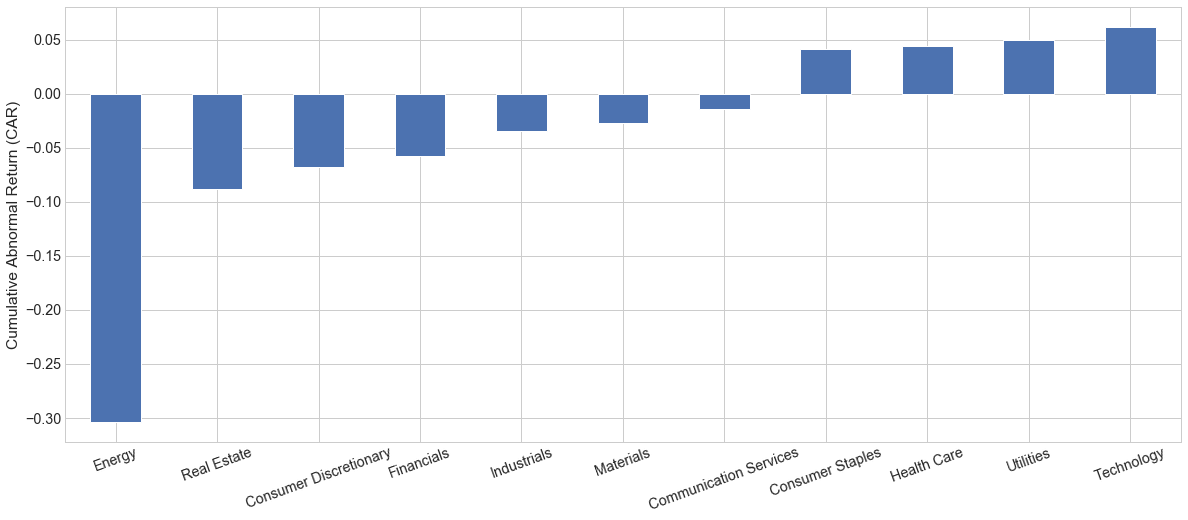

In [40]:
#Plot cumulative abnormal returns for each sector

event_days_sum= event_days.groupby("Name").sum()
event_days_sum = event_days_sum.sort_values(['Abnormal Return'], ascending=[1])

sns.set(font_scale=1.3)
plt.style.use('seaborn-whitegrid')

fig = plt.figure()
event_days_sum[['Abnormal Return']].plot.bar(figsize=(20,8), title = '', legend = False, rot=20)
plt.xlabel("")
plt.ylabel("Cumulative Abnormal Return (CAR)")


plt.savefig('sectors_cum_abn_returns.png')
plt.show()
#plt.close()

,Name,Log Return
Date,,
2019-11-30,Communication Services,0.059599
2019-12-31,Communication Services,0.088111
2020-01-31,Communication Services,0.142146
2020-02-29,Communication Services,0.246938
2020-03-31,Communication Services,0.849289


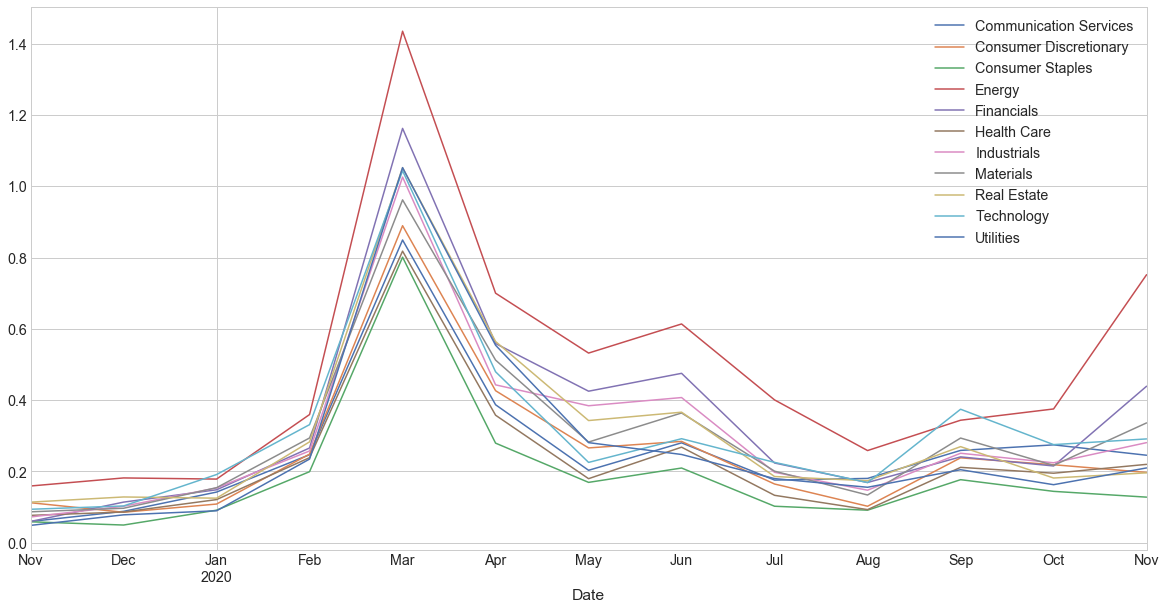

In [41]:
#3 Covid Cases and Volatility of Sectors

sector= sector.set_index('Date')
monthly_mean = sector.groupby("Name")['Log Return'].resample('M').mean()
monthly_std = sector.groupby("Name")['Log Return'].resample('M').std()
annualized_std = sector.groupby('Name')['Log Return'].resample('M').std()*np.sqrt(252)
annualized_std = pd.DataFrame(annualized_std).reset_index()
annualized_std = annualized_std.set_index('Date')

#statistics = pd.concat([(monthly_mean), (monthly_std), (annualized_std)], 
                             #axis = 'columns', join = 'inner')

#names = ['mean', 'std', 'annualized volatility']

#statistics.columns = names

#print(statistics)
#statistics.plot.bar(figsize=(20,10), title = 'Mean and Standard Deviation for Each Month')
annualized_std.groupby("Name")["Log Return"].plot(figsize=(20,10), title = '',
                   legend = True)

#statistics.head()
annualized_std.head()